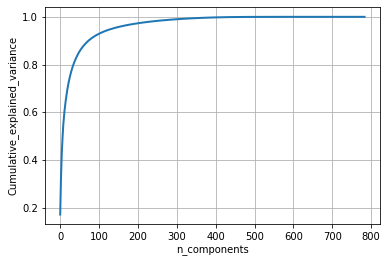

66.0

In [1]:

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import random
%matplotlib inline


def split_dataset (dataset ,split_ratio): # numpy
    training_set = []
    training_size = int(len(dataset)*split_ratio)
    temp_test_dataset = list(dataset)
    random_row_number = 0
    random_row = []
    while (len(training_set)<training_size):
        random_row_number = random.randrange(len(temp_test_dataset))
        random_row = temp_test_dataset.pop(random_row_number)
        training_set.append(random_row)
    test_dataset = temp_test_dataset
    return [training_set, test_dataset]



def mean(numbers):
    return sum(numbers)/float(len(numbers))

def stdev(numbers):
    avg = mean(numbers)
    variance = sum([pow(x-avg,2) for x in numbers])/float(len(numbers)-1)
    return math.sqrt(variance)


def categorize_into_classes (dataset):
    list_of_classes = []
    list_of_classes = np.unique(dataset[:,-1])
    
    classes_features_dict = {}
    
    for i in list_of_classes:
        
        data_for_the_class =  dataset[dataset[:,-1]==i].copy()
        data_for_the_class = data_for_the_class[:,:-1].copy() # cutting off the last column
        classes_features_dict[i] = data_for_the_class
    
    return classes_features_dict




def generate_stats(dataset):
    temp_mean = 0
    std_dev = 0
    stats_array = []
    # dataset = dataset[:,:-1].copy() # removed the last column
    index = 0
#     print(np.size(dataset,1))
    for index in range(np.size(dataset,1)):
        temp_mean = mean(dataset[:,index])
        std_dev = stdev(dataset[:,index])
        if (std_dev==0):
            std_dev = 0.0000022
        stats_array.append([temp_mean,std_dev])
        
    return stats_array

def generate_stats_by_class(dataset):

    classes_features_dict = categorize_into_classes (dataset)
#     print(classes_features_dict)
    class_wise_stats = {}
    for class_value, class_data in classes_features_dict.items():
        
        class_wise_stats[class_value] = generate_stats(class_data)

    
    return class_wise_stats

def calculate_probability(value, mean, stdev):
    
    exponent = math.exp(-(math.pow(value-mean,2)/(2*math.pow(stdev,2))))
    return (1 / (math.sqrt(2*math.pi) * stdev)) * exponent


def calculate_all_probabilities(class_wise_stats, input_vector):
    probabilities = {}
#     print(class_wise_stats[2])
    for class_value, class_stats in class_wise_stats.items():
        probabilities[class_value] = 1
        
        for i in range(len(class_stats)): #traversing through all feature dimensions
            
            mean = class_stats[i][0]
            stdev = class_stats[i][1]
            x = input_vector[i]
            p = calculate_probability(x, mean, stdev)
            
            if (p==0):
                p=1
#             print("class value = " + str(class_value) + "    " + str(p))
            p = math.log(p)
            probabilities[class_value] =  probabilities[class_value] + p
        
#     print(probabilities)
    return probabilities



def predict(class_wise_stats, input_vector):
    probabilities = calculate_all_probabilities(class_wise_stats, input_vector)
    label = None
    prob = -1
    
    for class_value, probability in probabilities.items():
        if label is None or probability > prob:
            prob = probability
            label = class_value
    return label


def get_predictions(class_wise_stats, test_dataset):
    predictions = []
    for i in range(len(test_dataset)):
        result = predict(class_wise_stats, test_dataset[i])
        predictions.append(result)
    return predictions

def getAccuracy(test_dataset, predictions):
    correct = 0
    for i in range(len(test_dataset)):
        if test_dataset[i][-1] == predictions[i]:
            correct += 1
    return (correct/float(len(test_dataset))) * 100.0

orig_dataset = pd.read_csv("DigitRecognizer.csv")



new_dataset = np.array(orig_dataset)

split_ratio = 0.75

training_set, test_dataset = split_dataset(new_dataset, split_ratio)

training_set = np.array(training_set)
test_dataset = np.array(test_dataset)

# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA


# n_components = 784

# pca = PCA(n_components=n_components, svd_solver='randomized',
#           whiten=True).fit(training_set[:6000,:-1])

# X_train_pca = pca.transform(training_set[:6000,:-1])

# X_train_pca=np.insert(X_train_pca,n_components,training_set[:6000,-1],axis=1)
    
# class_wise_stats = generate_stats_by_class(X_train_pca)


from sklearn import decomposition
dataset = np.array(orig_dataset)
pca = decomposition.PCA()
# PCA for dimensionality redcution (non-visualization)
pca.n_components = 784
pca_data = pca.fit_transform(dataset)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)


plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

class_wise_stats = generate_stats_by_class(training_set[0:6000,:])



predictions = get_predictions(class_wise_stats, test_dataset[0:500,:])

getAccuracy(test_dataset[0:500,:], predictions)

